In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lib import sig_gen
import tensorflow as tf
from tensorflow.keras import layers
from numba import jit, njit, prange

print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [25]:
@njit(parallel=True)
def sig_batch_gen(batch, symb, sps):
    """
    generate a signal batch
    no distortion yet
    """
    mibt = np.random.random((batch, 2))*0.7+0.3
    sig = np.empty((batch, symb*sps, 2))
    for idx in prange(batch):
        msg = np.random.randint(0, 2, symb)
        sig_cpx = sig_gen.gfsk_mod(msg, sps, mibt[idx, 0], mibt[idx, 1])
        sig[idx, :, 0] = sig_cpx.real
        sig[idx, :, 1] = sig_cpx.imag
    return sig, mibt

# sig, mibt = sig_batch_gen(batch, symb, sps)
# print(sig.shape, mibt.shape)
def train_generator(batch, symb, sps):
    while True:
        yield sig_batch_gen(batch, symb, sps)

        
batch = 1024*2
symb, sps = 64, 4
gen = train_generator(batch, symb, sps)
next(gen)[1].shape

(2048, 2)

In [26]:

%timeit sig_batch_gen(batch, symb, sps)

5.67 ms ± 72.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
def build_model(input_shape):
    # build model
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(32, 9, activation='relu',
                            input_shape=input_shape))
#     model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(16, 7, activation='relu'))
#     model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(8, 3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(2))

    model.compile(optimizer='Adam',
                  loss='mae')
    model.summary()

    return model

model = build_model((symb*sps, 2))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 248, 32)           608       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 242, 16)           3600      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 240, 8)            392       
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3842      
Total params: 8,442
Trainable params: 8,442
Non-trainable params: 0
_________________________________________________________________


In [6]:
# sanity check
x_test = np.random.rand(5, 256, 2)
model.predict(x_test).shape

(5, 2)

In [37]:
history = model.fit_generator(
    gen,
    steps_per_epoch=100,
    epochs=10
    )
model.save('mibt_est.h5')

Epoch 1/10
100/100 [==============================] - 2s 24ms/step - loss: 0.0890
Epoch 2/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0882
Epoch 3/10
100/100 [==============================] - 2s 24ms/step - loss: 0.0869
Epoch 4/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0854
Epoch 5/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0858
Epoch 6/10
100/100 [==============================] - 2s 24ms/step - loss: 0.0859
Epoch 7/10
100/100 [==============================] - 2s 24ms/step - loss: 0.0858
Epoch 8/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0856
Epoch 9/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0863
Epoch 10/10
100/100 [==============================] - 2s 23ms/step - loss: 0.0858


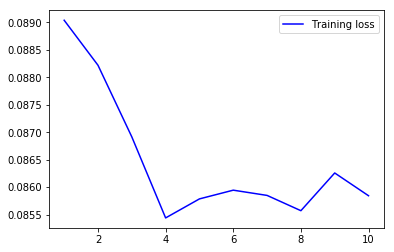

In [38]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.legend()
plt.show()

In [39]:
batch = 1
symb, sps = 64, 4
x_test, target = sig_batch_gen(batch, symb, sps)
print(model.predict(x_test), target)


[[0.6305957  0.65948814]] [[0.62718925 0.65202308]]
